In [1]:
import pandas
import seaborn
import time

from lib.compiler import Compiler
from lib.models.generic_v0.model import mappable_params

from lib.models.aft20barzur import BitcoinSM as AFT20BarZur
from lib.models.fc16sapirshtein import BitcoinSM as FC16Sapirshtein

from lib.models.generic_v1 import protocols as g1
from lib.models.generic_v1.model import SingleAgent as G1Model

from lib.models.generic_v0.bitcoin import Bitcoin as G0Bitcoin
from lib.models.generic_v0.model import SelfishMining as G0Model

In [2]:
network = mappable_params

models = []
implicit_mdps = []


def add_model(*, implicit_mdp, **model):
    models.append(model)
    implicit_mdps.append(implicit_mdp)


add_model(
    problem="ref-fc16",
    model="fc16sapirshtein",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=lambda c: FC16Sapirshtein(
        **network,
        maximum_dag_size=c,
        maximum_fork_length=0,
    ),
)

add_model(
    problem="ref-aft20",
    model="aft20barzur",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=lambda c: AFT20BarZur(
        **network, maximum_dag_size=c, maximum_fork_length=0
    ),
)


# our baseline: garbage collection + common chain truncation
# we want to compare to:
# - no common chain truncation (all infinite)
# - no garbage collection (infinite for protocols that allow stale blocks)
# - plus force-consider-own
# - plus merge-isomorphic
# - plus both


def add_problem(
    problem,
    *,
    collect_garbage=True,
    truncate_common_chain=True,
    force_consider_own=False,
    merge_isomorphic=False,
):
    def f(protocol_s, protocol_C, **protocol_args):
        model_args = dict(
            force_consider_own=force_consider_own,
            merge_isomorphic=merge_isomorphic,
            truncate_common_chain=truncate_common_chain,
            collect_garbage=collect_garbage,
            reward_common_chain=True,
        )
        add_model(
            problem=problem,
            model="generic-v1",
            protocol=protocol_s,
            **model_args,
            implicit_mdp=lambda c: G1Model(
                protocol_C,
                **protocol_args,
                **network,
                **model_args,
                dag_size_cutoff=c,
            ),
        )

    f("bitcoin", g1.Bitcoin)
    f("ethereum_3", g1.Ethereum, h=3)
    f("byzantium_3", g1.Byzantium, h=3)
    f("ghostdag_3", g1.Ghostdag, k=3)
    f("parallel_3", g1.Parallel, k=3)


add_problem("v1")
# add_problem("v1-gc", collect_garbage=False)
# add_problem("v1-tc", truncate_common_chain=False)
add_problem("v1+fc", force_consider_own=True)
add_problem("v1+n", merge_isomorphic=True)
add_problem("v1+fc+n", force_consider_own=True, merge_isomorphic=True)


add_model(
    problem="v0+fc+n",
    model="generic-v0",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=lambda c: G0Model(
        G0Bitcoin(),
        **network,
        maximum_size=c,
        force_consider_own=True,
        merge_isomorphic=True,
    ),
)

add_model(
    problem="v0",
    model="generic-v0",
    force_consider_own=False,
    merge_isomorphic=False,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=lambda c: G0Model(
        G0Bitcoin(),
        **network,
        maximum_size=c,
        force_consider_own=False,
        merge_isomorphic=False,
    ),
)

models = pandas.DataFrame(models)
models

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol
0,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin
1,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin
2,v1,generic-v1,False,False,True,True,True,bitcoin
3,v1,generic-v1,False,False,True,True,True,ethereum_3
4,v1,generic-v1,False,False,True,True,True,byzantium_3
5,v1,generic-v1,False,False,True,True,True,ghostdag_3
6,v1,generic-v1,False,False,True,True,True,parallel_3
7,v1+fc,generic-v1,True,False,True,True,True,bitcoin
8,v1+fc,generic-v1,True,False,True,True,True,ethereum_3
9,v1+fc,generic-v1,True,False,True,True,True,byzantium_3


In [3]:
!mkdir -p 5-generated-mdps

In [4]:
from IPython.display import display, clear_output
import gc
import psutil
import pickle
import gzip

max_size = 100000
max_size = 5000
aborts = []
size_log = []


def get_rss():
    gc.collect()
    return psutil.Process().memory_info().rss / 1024**3  # GiB


def explore(m):
    c = Compiler(m)
    while not_done := c.explore(steps=1000):
        if c.n_states > max_size:
            break
    done = not not_done
    return (done, c)


def _explore_row_limit(idx, row, dag_size_limit):
    m = implicit_mdps[idx](dag_size_limit)
    start_time = time.monotonic()
    done, c = explore(m)

    info = row.to_dict() | dict(
        dag_size_limit=dag_size_limit,
        size=c.n_states,
        time_spent=time.monotonic() - start_time,
        rss=get_rss(),
    )

    # report to stdout
    print(
        "\r"
        + "\t".join(
            [
                f"{k}: {info[k]}"
                for k in [
                    "problem",
                    "protocol",
                    "dag_size_limit",
                    "size",
                    "time_spent",
                    "rss",
                ]
            ]
            + [f"done: {done}                      "]
        ),
        end="",
    )

    if not done:
        aborts.append(info)
    else:
        mdp_key = format(abs(hash(frozenset(info.items()))), "08x")[0:8]
        size_log.append(info | dict(mdp=mdp_key))
        with gzip.open(f"5-generated-mdps/mdp-{mdp_key}.pkl.gz", "wb") as f:
            pickle.dump(c.mdp(finish_exploration=False), f)

    return done


memo = dict()


def explore_row_limit(idx, row, dag_size_limit):
    key = (idx, dag_size_limit)
    if key not in memo:
        memo[key] = _explore_row_limit(idx, row, dag_size_limit)
    return memo[key]

In [5]:
# locate the upper limit for exploring the non-generic reference models with binary search
for idx, row in models.iterrows():
    dag_size_limit = 1
    while True:
        dag_size_limit *= 2
        done = explore_row_limit(idx, row, dag_size_limit)
        if not done:
            break

    a = dag_size_limit / 2
    b = dag_size_limit

    while b - a > 1:
        c = round((a + b) / 2)
        done = explore_row_limit(idx, row, c)
        if done:
            a = c
        else:
            b = c

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 2	size: 3	time_spent: 0.00024906899852794595	rss: 0.17316818237304688	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 16	size: 402	time_spent: 0.01366906899784226	rss: 0.17377853393554688	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 32	size: 1698	time_spent: 0.06016172999807168	rss: 0.17646408081054688	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 48	size: 3890	time_spent: 0.1373595499971998	rss: 0.17997360229492188	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 56	size: 5026	time_spent: 0.17466536800202448	rss: 0.18351364135742188	done: False                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 52	size: 4578	time_spent: 0.15806874400004745	rss: 0.183502197265625	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 54	size: 4943	time_spent: 0.17428032499810797	rss: 0.18349456787109375	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 16	size: 297	time_spent: 0.00739658599923132	rss: 0.18213272094726562	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 64	size: 5025	time_spent: 0.13046451599802822	rss: 0.18237686157226562	done: False                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 56	size: 3837	time_spent: 0.09851374599747942	rss: 0.18219375610351562	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 60	size: 4411	time_spent: 0.11380846099928021	rss: 0.18219375610351562	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 62	size: 4713	time_spent: 0.12156283999865991	rss: 0.18219375610351562	done: True                      

problem: v1	protocol: bitcoin	dag_size_limit: 2	size: 6	time_spent: 0.0020354659973236267	rss: 0.18219375610351562	done: True                      

problem: v1	protocol: bitcoin	dag_size_limit: 4	size: 267	time_spent: 0.08192178099852754	rss: 0.18219375610351562	done: True                      

problem: v1	protocol: bitcoin	dag_size_limit: 8	size: 7369	time_spent: 2.632267712000612	rss: 0.23065567016601562	done: False                      

problem: v1	protocol: bitcoin	dag_size_limit: 6	size: 5364	time_spent: 2.130577814998105	rss: 0.23981094360351562	done: False                      

problem: v1	protocol: ethereum_3	dag_size_limit: 2	size: 6	time_spent: 0.0022669219979434274	rss: 0.20465469360351562	done: True                      

problem: v1	protocol: ethereum_3	dag_size_limit: 4	size: 327	time_spent: 0.12119424699994852	rss: 0.20392227172851562	done: True                      

problem: v1	protocol: ethereum_3	dag_size_limit: 8	size: 7442	time_spent: 2.819444493001356	rss: 0.23108291625976562	done: False                      

problem: v1	protocol: ethereum_3	dag_size_limit: 6	size: 5424	time_spent: 2.396339150996937	rss: 0.24060440063476562	done: False                      

problem: v1	protocol: byzantium_3	dag_size_limit: 2	size: 6	time_spent: 0.002370083999267081	rss: 0.21038436889648438	done: True                      

problem: v1	protocol: byzantium_3	dag_size_limit: 4	size: 327	time_spent: 0.12927752300311113	rss: 0.20950698852539062	done: True                      

problem: v1	protocol: byzantium_3	dag_size_limit: 8	size: 7442	time_spent: 2.915163632002077	rss: 0.23123550415039062	done: False                      

problem: v1	protocol: byzantium_3	dag_size_limit: 6	size: 5424	time_spent: 2.4463200789978146	rss: 0.24075698852539062	done: False                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 2	size: 6	time_spent: 0.002228187000582693	rss: 0.21100997924804688	done: True                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 4	size: 352	time_spent: 0.15671552699859603	rss: 0.21052169799804688	done: True                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 8	size: 7540	time_spent: 2.958075948001351	rss: 0.22980880737304688	done: False                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 6	size: 5299	time_spent: 2.42491097400125	rss: 0.23823165893554688	done: False                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 5	size: 3712	time_spent: 2.4419430929992814	rss: 0.23823165893554688	done: True                      

problem: v1	protocol: parallel_3	dag_size_limit: 4	size: 206	time_spent: 0.07023943199965288	rss: 0.22198867797851562	done: True                      

problem: v1	protocol: parallel_3	dag_size_limit: 8	size: 6718	time_spent: 2.822449813997082	rss: 0.23016738891601562	done: False                      

problem: v1	protocol: parallel_3	dag_size_limit: 6	size: 5603	time_spent: 3.3600748099997872	rss: 0.23895645141601562	done: False                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 4	size: 58	time_spent: 0.020006288003060035	rss: 0.21075439453125	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 8	size: 4968	time_spent: 3.3158340570007567	rss: 0.22161865234375	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 16	size: 5911	time_spent: 3.5239889149997907	rss: 0.23297119140625	done: False                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 12	size: 5911	time_spent: 3.6391719999992347	rss: 0.24273681640625	done: False                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 10	size: 5542	time_spent: 3.54312934599875	rss: 0.24273681640625	done: False                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 9	size: 5072	time_spent: 3.2650814879998507	rss: 0.24273681640625	done: False                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 4	size: 78	time_spent: 0.03335270000025048	rss: 0.21477127075195312	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 8	size: 5061	time_spent: 2.8865987799981667	rss: 0.22014236450195312	done: False                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 6	size: 1179	time_spent: 0.6439555930010101	rss: 0.22404861450195312	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 7	size: 4123	time_spent: 2.7295403280004393	rss: 0.22365951538085938	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 4	size: 78	time_spent: 0.03625386199928471	rss: 0.21403884887695312	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 8	size: 5022	time_spent: 3.151713473998825	rss: 0.21977615356445312	done: False                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 6	size: 1109	time_spent: 0.6765886510002019	rss: 0.22307205200195312	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 7	size: 3952	time_spent: 2.9477459240006283	rss: 0.2223663330078125	done: True                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 4	size: 84	time_spent: 0.04636103699886007	rss: 0.2134552001953125	done: True                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 8	size: 5802	time_spent: 3.8564108199971088	rss: 0.2241973876953125	done: False                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 6	size: 1527	time_spent: 1.2827319169991824	rss: 0.2290802001953125	done: True                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 7	size: 5775	time_spent: 4.549653772999591	rss: 0.2290802001953125	done: False                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 4	size: 119	time_spent: 0.04356150699823047	rss: 0.21995925903320312	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 8	size: 5219	time_spent: 2.370721904000675	rss: 0.22069168090820312	done: False                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 6	size: 2050	time_spent: 0.9317575929999293	rss: 0.23057937622070312	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 7	size: 5614	time_spent: 2.8796404770000663	rss: 0.23070144653320312	done: False                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 4	size: 198	time_spent: 0.09233329899871023	rss: 0.21982574462890625	done: True                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 8	size: 7452	time_spent: 5.542507050002314	rss: 0.23569488525390625	done: False                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 6	size: 5282	time_spent: 5.075027457998658	rss: 0.24350738525390625	done: False                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 2	size: 6	time_spent: 0.0029650680007762276	rss: 0.223846435546875	done: True                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 4	size: 231	time_spent: 0.12194487799933995	rss: 0.22366714477539062	done: True                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 8	size: 5193	time_spent: 3.8987251990001823	rss: 0.22366714477539062	done: False                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 6	size: 5491	time_spent: 4.759749304997968	rss: 0.22464370727539062	done: False                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 2	size: 6	time_spent: 0.003124737999314675	rss: 0.21886062622070312	done: True                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 4	size: 231	time_spent: 0.12723327999992762	rss: 0.21861648559570312	done: True                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 8	size: 5193	time_spent: 4.013702762000321	rss: 0.21873855590820312	done: False                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 6	size: 5490	time_spent: 4.95889449400056	rss: 0.22472000122070312	done: False                      

problem: v1+n	protocol: ghostdag_3	dag_size_limit: 2	size: 6	time_spent: 0.0029149740003049374	rss: 0.21887588500976562	done: True                      

problem: v1+n	protocol: ghostdag_3	dag_size_limit: 4	size: 228	time_spent: 0.13436652599921217	rss: 0.21863174438476562	done: True                      

problem: v1+n	protocol: ghostdag_3	dag_size_limit: 8	size: 5545	time_spent: 4.038072348001151	rss: 0.21875381469726562	done: False                      

problem: v1+n	protocol: ghostdag_3	dag_size_limit: 6	size: 5807	time_spent: 4.893851105000067	rss: 0.22510147094726562	done: False                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 2	size: 51	time_spent: 0.023323249999521067	rss: 0.22202301025390625	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 4	size: 152	time_spent: 0.07933481800137088	rss: 0.22104644775390625	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 8	size: 5110	time_spent: 5.468507211000542	rss: 0.22336578369140625	done: False                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 6	size: 1654	time_spent: 1.3833158890010964	rss: 0.22763824462890625	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 7	size: 5492	time_spent: 5.54416680400027	rss: 0.2269439697265625	done: False                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 4	size: 45	time_spent: 0.023147961001086514	rss: 0.2208404541015625	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 8	size: 1959	time_spent: 1.948820555000566	rss: 0.2208404541015625	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 16	size: 5261	time_spent: 5.267608526999538	rss: 0.2293853759765625	done: False                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 12	size: 5200	time_spent: 5.410237922002125	rss: 0.2391510009765625	done: False                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 10	size: 6203	time_spent: 6.803228375996696	rss: 0.2391510009765625	done: False                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 9	size: 5152	time_spent: 6.022233455001697	rss: 0.2490386962890625	done: False                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 4	size: 56	time_spent: 0.03419772699999157	rss: 0.22717666625976562	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 8	size: 5213	time_spent: 5.087534205002157	rss: 0.22668838500976562	done: False                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 6	size: 596	time_spent: 0.4643328929996642	rss: 0.22582244873046875	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 2	size: 5	time_spent: 0.003153913999994984	rss: 0.22344970703125	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 4	size: 56	time_spent: 0.03772918100003153	rss: 0.22296142578125	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 8	size: 5169	time_spent: 5.555203344996698	rss: 0.22467041015625	done: False                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 6	size: 572	time_spent: 0.4928206949989544	rss: 0.22467041015625	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 2	size: 5	time_spent: 0.002760285002295859	rss: 0.22301101684570312	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 4	size: 57	time_spent: 0.03908547799801454	rss: 0.22227859497070312	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 8	size: 5865	time_spent: 6.527556033001019	rss: 0.22740554809570312	done: False                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 6	size: 604	time_spent: 0.6468151680019218	rss: 0.22705078125	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 2	size: 41	time_spent: 0.02292398999998113	rss: 0.22513580322265625	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 4	size: 84	time_spent: 0.051585588000307325	rss: 0.22343063354492188	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 8	size: 2320	time_spent: 2.6956826509995153	rss: 0.22343063354492188	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 16	size: 6369	time_spent: 8.019095946998277	rss: 0.24271774291992188	done: False                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 12	size: 6232	time_spent: 7.899056299000222	rss: 0.2539482116699219	done: False                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 10	size: 5565	time_spent: 6.850924760001362	rss: 0.2539482116699219	done: False                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 9	size: 4967	time_spent: 6.127196654000727	rss: 0.2539482116699219	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 4	size: 104	time_spent: 0.046696556000824785	rss: 0.22751617431640625	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 8	size: 1652	time_spent: 1.2525368199967488	rss: 0.22751617431640625	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 16	size: 5430	time_spent: 4.807191202999093	rss: 0.2303924560546875	done: False                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 12	size: 5068	time_spent: 4.563729907997185	rss: 0.22989273071289062	done: False                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 10	size: 4315	time_spent: 4.012433203002729	rss: 0.22835159301757812	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 2	size: 18	time_spent: 0.003577643998141866	rss: 0.23133087158203125	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 4	size: 1198	time_spent: 0.4779084170004353	rss: 0.23133087158203125	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 8	size: 5909	time_spent: 2.087641120000626	rss: 0.23084259033203125	done: False                      

problem: v0	protocol: bitcoin	dag_size_limit: 6	size: 6835	time_spent: 3.0407811329969263	rss: 0.23084259033203125	done: False                      

problem: v0	protocol: bitcoin	dag_size_limit: 5	size: 5509	time_spent: 2.578263125000376	rss: 0.23084259033203125	done: False                      

In [6]:
for idx, row in models.iterrows():
    dag_size_limit = 1
    while True:
        dag_size_limit += 1

        if row["problem"].startswith("ref") and dag_size_limit >= 16:
            break

        done = explore_row_limit(idx, row, dag_size_limit)
        if not done:
            break

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 6	size: 47	time_spent: 0.0014768060027563479	rss: 0.23084259033203125	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 7	size: 67	time_spent: 0.002138099000148941	rss: 0.23084259033203125	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 10	size: 147	time_spent: 0.004892906999884872	rss: 0.23084259033203125	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 11	size: 181	time_spent: 0.005981222999253077	rss: 0.23084259033203125	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 13	size: 259	time_spent: 0.008476001999952132	rss: 0.23084259033203125	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 14	size: 303	time_spent: 0.010039931999926921	rss: 0.23084259033203125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 3	size: 8	time_spent: 0.00022585499755223282	rss: 0.23084259033203125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 5	size: 25	time_spent: 0.0006241730006877333	rss: 0.23084259033203125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 9	size: 89	time_spent: 0.002213630999904126	rss: 0.23084259033203125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 10	size: 111	time_spent: 0.00271495299966773	rss: 0.23084259033203125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 13	size: 193	time_spent: 0.0047395190013048705	rss: 0.23084259033203125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 14	size: 225	time_spent: 0.005394420000811806	rss: 0.23084259033203125	done: True                      

problem: v1	protocol: ethereum_3	dag_size_limit: 3	size: 45	time_spent: 0.016718987000786	rss: 0.23084259033203125	done: True                      

problem: v1	protocol: parallel_3	dag_size_limit: 3	size: 90	time_spent: 0.029634284001076594	rss: 0.23084259033203125	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 5	size: 186	time_spent: 0.07535188899782952	rss: 0.23084259033203125	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 6	size: 549	time_spent: 0.24517077899872675	rss: 0.23084259033203125	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 3	size: 41	time_spent: 0.01920657299706363	rss: 0.23084259033203125	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 3	size: 41	time_spent: 0.02047923499776516	rss: 0.23084259033203125	done: True                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 3	size: 23	time_spent: 0.011219810003240127	rss: 0.23084259033203125	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 3	size: 69	time_spent: 0.026347015002102125	rss: 0.23084259033203125	done: True                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 3	size: 78	time_spent: 0.038768231999711134	rss: 0.23084259033203125	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 3	size: 68	time_spent: 0.029334350001590792	rss: 0.23084259033203125	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 5	size: 120	time_spent: 0.07341857600113144	rss: 0.23084259033203125	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 6	size: 300	time_spent: 0.22276281800077413	rss: 0.23084259033203125	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 3	size: 29	time_spent: 0.01745618499990087	rss: 0.23084259033203125	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 3	size: 29	time_spent: 0.01928742800009786	rss: 0.23084259033203125	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 3	size: 19	time_spent: 0.011113818000012543	rss: 0.23084259033203125	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 3	size: 50	time_spent: 0.025433045000681886	rss: 0.23084259033203125	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 5	size: 191	time_spent: 0.13304154200159246	rss: 0.23084259033203125	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 6	size: 462	time_spent: 0.3658797649986809	rss: 0.23084259033203125	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 3	size: 41	time_spent: 0.013422108997474425	rss: 0.23084259033203125	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 5	size: 248	time_spent: 0.12621217099876958	rss: 0.23084259033203125	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 6	size: 501	time_spent: 0.3126000970005407	rss: 0.23084259033203125	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 7	size: 951	time_spent: 0.6582143230007205	rss: 0.23084259033203125	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 3	size: 175	time_spent: 0.04668937599853962	rss: 0.23084259033203125	done: True                      

In [7]:
size_log = pandas.DataFrame(size_log)
aborts = pandas.DataFrame(aborts)

size_log.to_pickle("5-generated-mdps/success.pkl.gz")
aborts.to_pickle("5-generated-mdps/fail.pkl.gz")

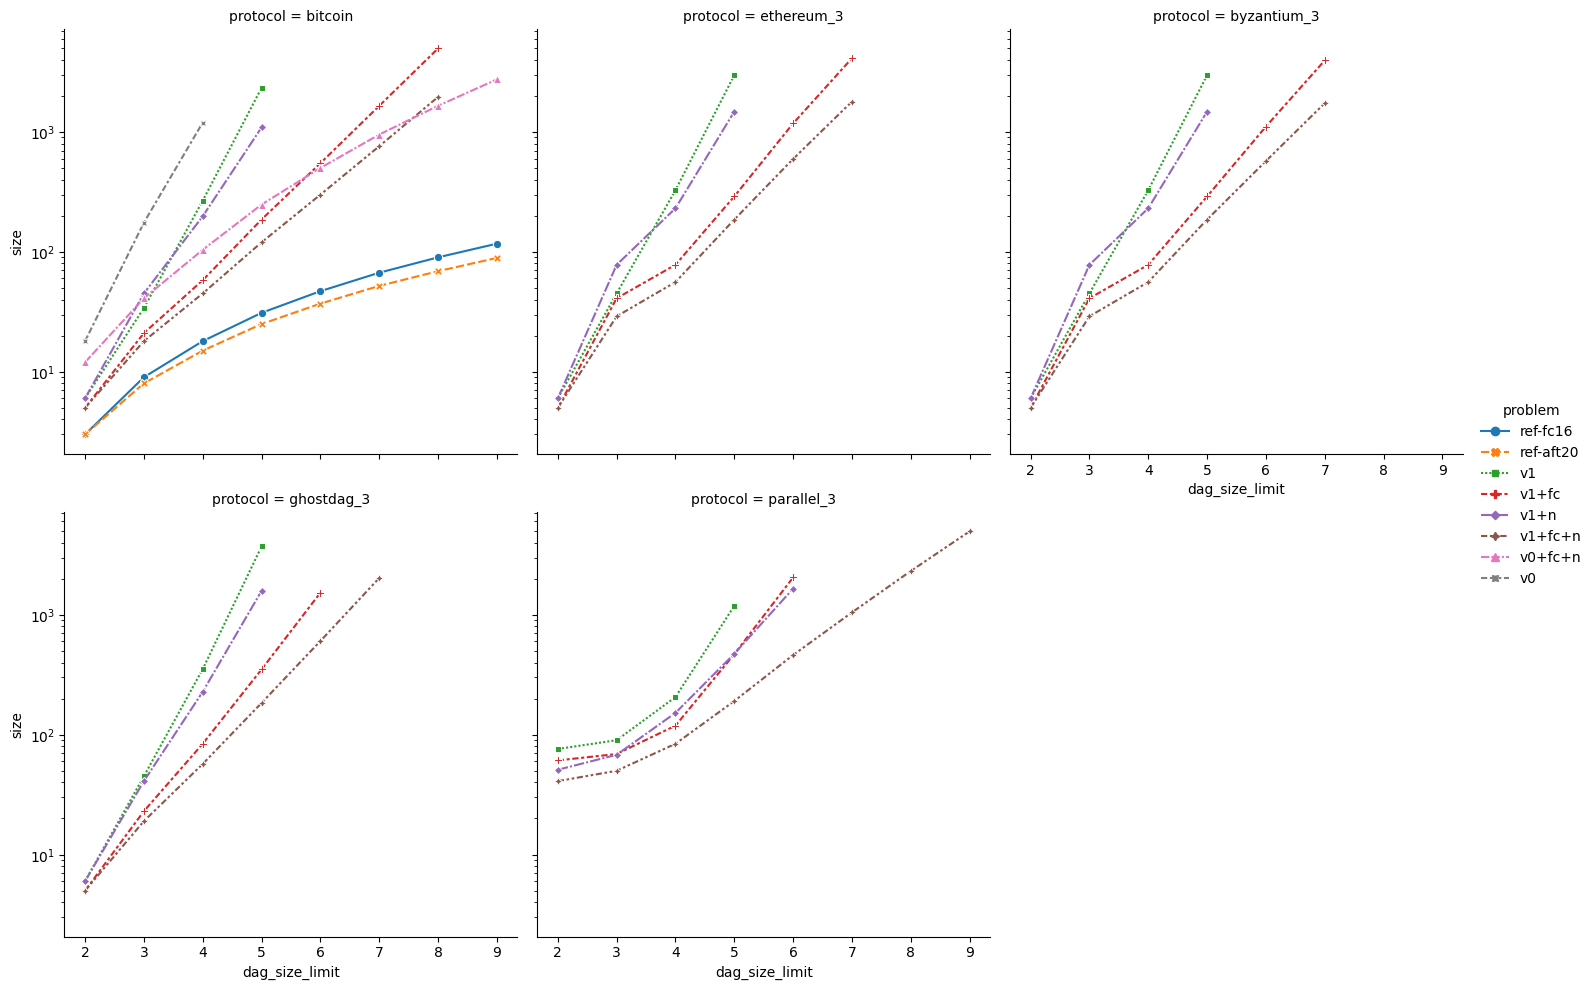

In [8]:
seaborn.relplot(
    data=size_log.query("dag_size_limit < 10"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="problem",
    style="problem",
    markers=True,
    col="protocol",
    col_wrap=3,
).set(yscale="log")